<a href="https://colab.research.google.com/github/hufexv/Basic_python_code/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn import functional as F

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [94]:
#一:处理数据
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [104]:
data.isna().sum()
#test.isna().sum()
X_train_processed.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Rev,Embarked_0,Embarked_1,Embarked_2
331,1,0,45.500000,0,0,28.5000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
733,2,0,23.000000,0,0,13.0000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
382,3,0,32.000000,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
704,3,0,26.000000,1,0,7.8542,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
813,3,1,6.000000,4,2,31.2750,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
118,1,0,24.000000,0,1,247.5208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
536,1,0,45.000000,0,0,26.5500,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
361,2,0,29.000000,1,0,27.7208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
29,3,0,29.699118,0,0,7.8958,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55,1,0,29.699118,0,0,35.5000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [95]:
#处理data
# 从 Name 中提取头衔（如 Mr., Mrs., Dr.）
data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 查看提取的头衔分布
print(data['Title'].value_counts())

# 将头衔映射为更通用的类别
title_mapping = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
    'Dr': 'Dr', 'Rev': 'Rev', 'Major': 'Officer', 'Col': 'Officer',
    # 其他头衔映射...
}
data['Title'] = data['Title'].map(title_mapping).fillna('Other')

# 删除原始 Name 列
data = data.drop('Name', axis=1)

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


In [96]:
#处理test
# 从 Name 中提取头衔（如 Mr., Mrs., Dr.）
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 查看提取的头衔分布
print(test['Title'].value_counts())

# 将头衔映射为更通用的类别
title_mapping = {
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Miss': 'Miss', 'Master': 'Master',
    'Dr': 'Dr', 'Rev': 'Rev', 'Major': 'Officer', 'Col': 'Officer',
    # 其他头衔映射...
}
test['Title'] = test['Title'].map(title_mapping).fillna('Other')

# 删除原始 Name 列
test = test.drop('Name', axis=1)

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64


In [97]:
data['Age'] = data['Age'].fillna(data['Age'].mean())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
if 'Cabin' in data.columns:
    data = data.drop('Cabin', axis=1)
    print("已删除 Cabin 列")
else:
    print("Cabin 列不存在，跳过删除")

if 'PassengerId' in data.columns:
    data = data.drop('PassengerId', axis=1)
    print("已删除 PassengerId 列")
else:
    print("PassengerId 列不存在，跳过删除")

if 'Ticket' in data.columns:
    data = data.drop('Ticket', axis=1)
    print("已删除 Ticket 列")
else:
    print("Ticket 列不存在，跳过删除")

已删除 Cabin 列
已删除 PassengerId 列
已删除 Ticket 列


In [98]:
test_passenger_id = test['PassengerId'].copy()
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])
if 'Cabin' in test.columns:
    test = test.drop('Cabin', axis=1)
    print("已删除 Cabin 列")
else:
    print("Cabin 列不存在，跳过删除")

if 'PassengerId' in test.columns:
    test = test.drop('PassengerId', axis=1)
    print("已删除 PassengerId 列")
else:
    print("PassengerId 列不存在，跳过删除")

if 'Ticket' in test.columns:
    test = test.drop('Ticket', axis=1)
    print("已删除 Ticket 列")
else:
    print("Ticket 列不存在，跳过删除")

已删除 Cabin 列
已删除 PassengerId 列
已删除 Ticket 列


/tmp/ipython-input-87-1978645233.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = data.groupby(['FareGroup', 'Survived']).size().unstack()


票价区间与生存情况：
                   dead  live  total  live_rate(%)
FareGroup                                         
(-0.001, 7.854]     140    39    179         21.79
(7.854, 10.5]       147    37    184         20.11
(10.5, 21.679]       99    73    172         42.44
(21.679, 39.688]    100    80    180         44.44
(39.688, 512.329]    63   113    176         64.20


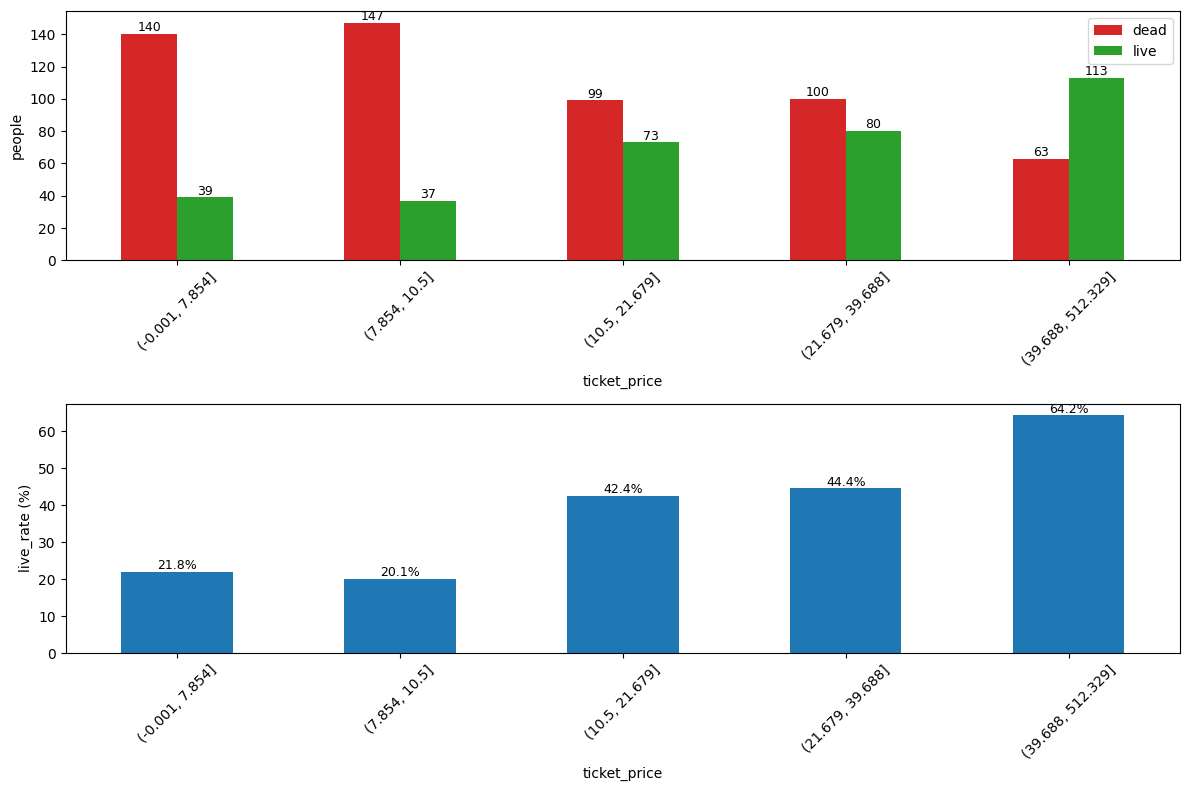

In [87]:
#visualize x_y
# 检查 Survived 列是否存在
if 'Survived' not in data.columns:
    print(f"数据中不存在 'Survived' 列。可用列名：{data.columns.tolist()}")
    exit()

# 创建票价区间（分箱）
data['FareGroup'] = pd.qcut(data['Fare'], q=5)  # 将票价分为5个区间

# 计算每个票价区间的生存和死亡人数
fare_survival = data.groupby(['FareGroup', 'Survived']).size().unstack()
fare_survival.columns = ['dead', 'live']  # 重命名列

# 计算每个票价区间的总人数和生存率
fare_survival['total'] = fare_survival.sum(axis=1)
fare_survival['live_rate(%)'] = round(fare_survival['live'] / fare_survival['total'] * 100, 2)

print("票价区间与生存情况：")
print(fare_survival)

# 创建画布
plt.figure(figsize=(12, 8))

# 1. 绘制生存与死亡人数的柱状图
ax1 = plt.subplot(2, 1, 1)
fare_survival[['dead', 'live']].plot(kind='bar', ax=ax1, color=['#d62728', '#2ca02c'])

plt.xlabel('ticket_price')
plt.ylabel('people')
plt.xticks(rotation=45)

# 添加数据标签
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9)

# 2. 绘制生存率的柱状图
ax2 = plt.subplot(2, 1, 2)
fare_survival['live_rate(%)'].plot(kind='bar', ax=ax2, color='#1f77b4')

plt.xlabel('ticket_price')
plt.ylabel('live_rate (%)')
plt.xticks(rotation=45)

# 添加数据标签
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.1f}%', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()  # 调整布局
plt.show()
data.drop('FareGroup', axis=1, inplace=True)

In [88]:
# 按 Embarked 和 Survived 分组，统计人数
survival_by_embarked = data.groupby('Embarked')['Survived'].value_counts().unstack()

# 设置列名（更直观）
survival_by_embarked.columns = ['Died', 'Survived']

print("不同 Embarked 的生存情况：")
print(survival_by_embarked)

不同 Embarked 的生存情况：
          Died  Survived
Embarked                
C           75        93
Q           47        30
S          427       219


In [99]:
# 特征工程
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
data['Embarked'] = data['Embarked'].map({'S':0, 'C':1, 'Q':2})

train_X = data.iloc[:, 1:]
train_Y = data['Survived']

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    train_X, train_Y, test_size=0.2, random_state=42
)

In [100]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 对分类列进行独热编码
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = ['Title', 'Embarked']  # 分类列

# 1. 仅用训练集拟合编码器（核心：只拟合一次）
encoder.fit(X_train[categorical_cols])  # 单独拟合，明确用训练集类别

# 2. 对训练集编码（用拟合好的编码器）
X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_cols]),  # 这里用 transform，不是 fit_transform
    columns=encoder.get_feature_names_out(categorical_cols)
)

# 3. 对验证集编码（用同一个编码器）
X_val_encoded = pd.DataFrame(
    encoder.transform(X_val[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)

# 4. 对测试集编码（关键：仅用 transform，复用训练集编码器）
test_encoded = pd.DataFrame(
    encoder.transform(test[categorical_cols]),  # 这里改 fit_transform 为 transform
    columns=encoder.get_feature_names_out(categorical_cols)
)

# 重置索引
X_train_encoded.index = X_train.index
X_val_encoded.index = X_val.index
test_encoded.index = test.index

# 合并特征
X_train_processed = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_encoded], axis=1)
X_val_processed = pd.concat([X_val.drop(categorical_cols, axis=1), X_val_encoded], axis=1)
test_processed = pd.concat([test.drop(categorical_cols, axis=1), test_encoded], axis=1)

# 验证特征名是否一致
print("训练集编码特征名：", X_train_encoded.columns.tolist())
print("测试集编码特征名：", test_encoded.columns.tolist())  # 此时应完全一致
print("处理后的训练集形状：", X_train_processed.shape)
print("处理后的测试集形状：", test_processed.shape)  # 特征数量应相同

训练集编码特征名： ['Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Other', 'Title_Rev', 'Embarked_0', 'Embarked_1', 'Embarked_2']
测试集编码特征名： ['Title_Dr', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Other', 'Title_Rev', 'Embarked_0', 'Embarked_1', 'Embarked_2']
处理后的训练集形状： (712, 17)
处理后的测试集形状： (418, 17)


In [91]:
# 检查各列的数据类型
print("数据类型检查：")
print(test_processed.dtypes)

# 找出所有非数值类型列
non_numeric_cols = test_processed.select_dtypes(exclude=['int', 'float', 'bool', 'category']).columns
print("\n非数值类型列：", non_numeric_cols.tolist())

数据类型检查：
PassengerId        int64
Pclass             int64
Sex               object
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Title_Dr         float64
Title_Master     float64
Title_Miss       float64
Title_Mr         float64
Title_Mrs        float64
Title_Officer    float64
Title_Other      float64
Title_Rev        float64
Embarked_0       float64
Embarked_1       float64
Embarked_2       float64
dtype: object

非数值类型列： ['Sex']


In [101]:
#二:训练

dtrain = xgb.DMatrix(X_train_processed, label=y_train)
dval = xgb.DMatrix(X_val_processed, label=y_val)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
    'max_depth': 3,
    'eta': 0.1,                      # 学习率
    'subsample': 0.8,                # 样本采样比例
    'colsample_bytree': 0.7,         # 特征采样比例
    'seed': 42
}

num_rounds = 100
evals = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=evals,
    early_stopping_rounds=10,
    verbose_eval=10
)
model.save_model('titanic_xgb.model')

[0]	train-error:0.37640	val-error:0.41341
[10]	train-error:0.15309	val-error:0.19553
[20]	train-error:0.15449	val-error:0.18994
[25]	train-error:0.15169	val-error:0.20670


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:53:43] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [38]:
#调参
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

print("最佳参数:", grid_search.best_params_)




最佳参数: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}


In [103]:
#三:预测
loaded_model = xgb.Booster()
loaded_model.load_model('titanic_xgb.model')

# 假设训练时对 'Sex' 用标签编码，'Embarked' 用映射
test_processed['Sex'] = test_processed['Sex'].map({'male': 0, 'female': 1})  # 与训练集映射规则一致
#test_processed['Embarked'] = test_processed['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})  # 与训练集一致

# 4. 检查数据类型（确保无 object 类型）
print("测试集数据类型检查：")
print(test_processed.dtypes)  # 应全部为 int/float


dtest_processed = xgb.DMatrix(test_processed)
test_processed_pred_proba = loaded_model.predict(dtest_processed)
test_processed_pred = np.round(test_processed_pred_proba)


submission = pd.DataFrame({
    'PassengerId': test_passenger_id,
    'Survived': test_processed_pred.astype(int)
})

submission.to_csv('submission.csv', index=False)


测试集数据类型检查：
Pclass             int64
Sex              float64
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Title_Dr         float64
Title_Master     float64
Title_Miss       float64
Title_Mr         float64
Title_Mrs        float64
Title_Officer    float64
Title_Other      float64
Title_Rev        float64
Embarked_0       float64
Embarked_1       float64
Embarked_2       float64
dtype: object
